In [1]:
# 필요 라이브러리 로딩
from __future__ import absolute_import, division
from __future__ import print_function, unicode_literals

import os
import time
import shutil
import functools

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image
from IPython.display import clear_output

import tensorflow as tf
import tensorflow_addons as tfa
print(tf.__version__)

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import models

2.3.1


In [2]:

DATASET_PATH=os.path.join(os.getenv('HOME'),'aiffel/medical')
'''
if not os.path.isdir(DATASET_PATH):
    os.makedirs(DATASET_PATH)

import urllib.request
u = urllib.request.urlopen(url='https://aiffelstaticprd.blob.core.windows.net/media/documents/sd_train.zip')
data = u.read()
u.close()

with open('sd_train.zip', "wb") as f :
    f.write(data)
    print('Data has been downloaded')

shutil.move(os.path.join('sd_train.zip'), os.path.join(DATASET_PATH))
file_path = os.path.join(DATASET_PATH, 'sd_train.zip')

import zipfile
zip_ref = zipfile.ZipFile(file_path, 'r')
zip_ref.extractall(DATASET_PATH)
zip_ref.close()
print('Data has been extracted.')
'''

'\nif not os.path.isdir(DATASET_PATH):\n    os.makedirs(DATASET_PATH)\n\nimport urllib.request\nu = urllib.request.urlopen(url=\'https://aiffelstaticprd.blob.core.windows.net/media/documents/sd_train.zip\')\ndata = u.read()\nu.close()\n\nwith open(\'sd_train.zip\', "wb") as f :\n    f.write(data)\n    print(\'Data has been downloaded\')\n\nshutil.move(os.path.join(\'sd_train.zip\'), os.path.join(DATASET_PATH))\nfile_path = os.path.join(DATASET_PATH, \'sd_train.zip\')\n\nimport zipfile\nzip_ref = zipfile.ZipFile(file_path, \'r\')\nzip_ref.extractall(DATASET_PATH)\nzip_ref.close()\nprint(\'Data has been extracted.\')\n'

In [3]:
img_dir = os.path.join(DATASET_PATH, "train")
label_dir = os.path.join(DATASET_PATH, "train_labels")

In [4]:
x_train_filenames = [os.path.join(img_dir, filename) for filename in os.listdir(img_dir)]
x_train_filenames.sort()
y_train_filenames = [os.path.join(label_dir, filename) for filename in os.listdir(label_dir)]
y_train_filenames.sort()

In [5]:
x_train_filenames, x_test_filenames, y_train_filenames, y_test_filenames = \
                    train_test_split(x_train_filenames, y_train_filenames, test_size=0.2)

In [6]:
num_train_examples = len(x_train_filenames)
num_test_examples = len(x_test_filenames)

print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples: {}".format(num_test_examples))

Number of training examples: 480
Number of test examples: 120


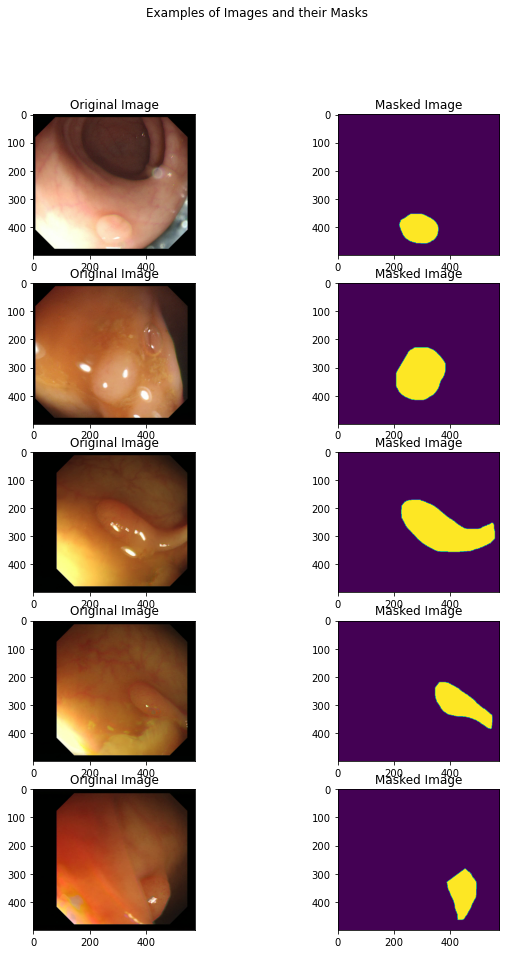

In [7]:
display_num = 5

r_choices = np.random.choice(num_train_examples, display_num)

plt.figure(figsize=(10, 15))
for i in range(0, display_num * 2, 2):
    img_num = r_choices[i // 2]
    x_pathname = x_train_filenames[img_num]
    y_pathname = y_train_filenames[img_num]

    plt.subplot(display_num, 2, i + 1)
    plt.imshow(Image.open(x_pathname))
    plt.title("Original Image")

    example_labels = Image.open(y_pathname)
    label_vals = np.unique(example_labels)

    plt.subplot(display_num, 2, i + 2)
    plt.imshow(example_labels)
    plt.title("Masked Image")
    
plt.suptitle("Examples of Images and their Masks")
plt.show()

In [8]:
# Set hyperparameters

image_size = 256
img_shape = (image_size, image_size, 3)
batch_size = 8
max_epochs = 50

In [9]:
def _process_pathnames(fname, label_path):
    # We map this function onto each pathname pair
    img_str = tf.io.read_file(fname)
    img = tf.image.decode_bmp(img_str, channels=3) # RGB

    label_img_str = tf.io.read_file(label_path)
    label_img = tf.image.decode_bmp(label_img_str, channels=1) # BMP 0,1

    resize = [image_size, image_size]
    img = tf.image.resize(img, resize)
    label_img = tf.image.resize(label_img, resize)

    scale = 1 / 255.
    img = tf.cast(img, dtype=tf.float32) * scale
    label_img = tf.cast(label_img, dtype=tf.float32) * scale

    return img, label_img

In [10]:
def shift_img(output_img, label_img, width_shift_range, height_shift_range):
    """This fn will perform the horizontal or vertical shift"""
    if width_shift_range or height_shift_range:
        if width_shift_range:
                width_shift_range = tf.random.uniform([],
                                                  -width_shift_range * img_shape[1],
                                                  width_shift_range * img_shape[1])
        if height_shift_range:
                height_shift_range = tf.random.uniform([],
                                                   -height_shift_range * img_shape[0],
                                                   height_shift_range * img_shape[0])
        output_img = tfa.image.translate(output_img,
                                         [width_shift_range, height_shift_range])
        label_img = tfa.image.translate(label_img,
                                        [width_shift_range, height_shift_range])
    return output_img, label_img

In [11]:
def flip_img(horizontal_flip, tr_img, label_img):
    if horizontal_flip:
        flip_prob = tf.random.uniform([], 0.0, 1.0)
        tr_img, label_img = tf.cond(tf.less(flip_prob, 0.5),
                                lambda: (tf.image.flip_left_right(tr_img), tf.image.flip_left_right(label_img)),
                                lambda: (tr_img, label_img))
    return tr_img, label_img

In [12]:
def _augment(img,
             label_img,
             resize=None,  # Resize the image to some size e.g. [256, 256]
             scale=1,  # Scale image e.g. 1 / 255.
             hue_delta=0.,  # Adjust the hue of an RGB image by random factor
             horizontal_flip=True,  # Random left right flip,
             width_shift_range=0.05,  # Randomly translate the image horizontally
             height_shift_range=0.05):  # Randomly translate the image vertically 
    if resize is not None:
        # Resize both images
        label_img = tf.image.resize(label_img, resize)
        img = tf.image.resize(img, resize)
  
    if hue_delta:
        img = tf.image.random_hue(img, hue_delta)
  
    img, label_img = flip_img(horizontal_flip, img, label_img)
    img, label_img = shift_img(img, label_img, width_shift_range, height_shift_range)
    label_img = tf.cast(label_img, dtype=tf.float32) * scale
    img = tf.cast(img, dtype=tf.float32) * scale
    return img, label_img

In [13]:
def get_baseline_dataset(filenames,
                         labels,
                         preproc_fn=functools.partial(_augment),
                         threads=4,
                         batch_size=batch_size,
                         is_train=True):
    num_x = len(filenames)
    # Create a dataset from the filenames and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    # Map our preprocessing function to every element in our dataset, taking
    # advantage of multithreading
    dataset = dataset.map(_process_pathnames, num_parallel_calls=threads)

    if is_train:# 학습을 진행할시에만 위에 augment를 진행합니다.
        #if preproc_fn.keywords is not None and 'resize' not in preproc_fn.keywords:
        #  assert batch_size == 1, "Batching images must be of the same size"
        dataset = dataset.map(preproc_fn, num_parallel_calls=threads)
        dataset = dataset.shuffle(num_x * 10)

    dataset = dataset.batch(batch_size)
    return dataset

In [14]:
train_dataset = get_baseline_dataset(x_train_filenames, # 학습 데이터
                                     y_train_filenames) # 정답 데이터
train_dataset = train_dataset.repeat()
test_dataset = get_baseline_dataset(x_test_filenames,
                                    y_test_filenames,
                                    is_train=False)
train_dataset

<RepeatDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 1)), types: (tf.float32, tf.float32)>

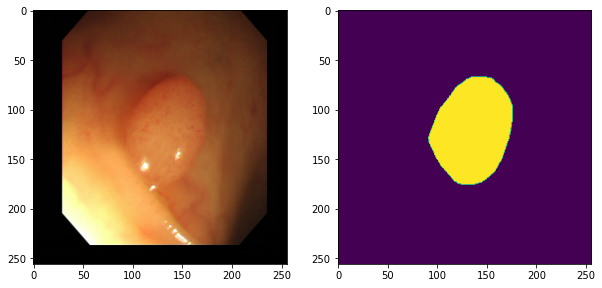

In [15]:
for images, labels in train_dataset.take(1):
    # Running next element in our graph will produce a batch of images
    plt.figure(figsize=(10, 10))
    img = images[0]

    plt.subplot(1, 2, 1)
    plt.imshow(img)

    plt.subplot(1, 2, 2)
    plt.imshow(labels[0, :, :, 0])
    plt.show()

In [16]:
# inputs: [batch_size, 256, 256, 3]
encoder = tf.keras.Sequential(name='encoder')

# conv-batchnorm-activation-maxpool
encoder.add(layers.Conv2D(64, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(64, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv1: [batch_size, 128, 128, 64]

encoder.add(layers.Conv2D(128, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(128, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv2: [batch_size, 64, 64, 128]

encoder.add(layers.Conv2D(256, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(256, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv3: [batch_size, 32, 32, 256]

encoder.add(layers.Conv2D(512, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(512, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv4-outputs: [batch_size, 16, 16, 512]

In [17]:
# Encoder 제대로 만들어졌는지 확인

bottleneck = encoder(tf.random.normal([batch_size, 256, 256, 3]))
print(bottleneck.shape)   # (batch_size, 16, 16, 512) 이 나오는지 확인

(8, 16, 16, 512)


In [18]:
# inputs: [batch_size, 16, 16, 512]
decoder = tf.keras.Sequential(name='decoder')

# conv_transpose-batchnorm-activation
decoder.add(layers.Conv2DTranspose(256, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv_transpose1: [batch_size, 32, 32, 256]
decoder.add(layers.Conv2D(256, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(128, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv_transpose2: [batch_size, 64, 64, 128]
decoder.add(layers.Conv2D(128, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv_transpose3: [batch_size, 128, 128, 64]
decoder.add(layers.Conv2D(64, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(32, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv transpose4-outputs: [batch_size, 256, 256, 32]
decoder.add(layers.Conv2D(32, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(1, 1, strides=1, padding='same', activation='sigmoid'))

In [19]:
# decoder 제대로 만들어졌는지 확인

predictions = decoder(bottleneck)
print(predictions.shape)    # (batch_size, 256, 256, 1) 이 나오는지 확인

(8, 256, 256, 1)


In [20]:
ed_model = tf.keras.Sequential()

ed_model.add(encoder)
ed_model.add(decoder)

In [21]:
class Conv(tf.keras.Model):
    def __init__(self, num_filters, kernel_size):
        super(Conv, self).__init__()
        self.conv = layers.Conv2D(num_filters, kernel_size, padding='same')
        self.bn = layers.BatchNormalization()

    def call(self, inputs, training=True):
        x = self.conv(inputs)
        x = self.bn(x, training=training)
        x = layers.ReLU()(x)

        return x

In [22]:
class ConvBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(ConvBlock, self).__init__()
        self.conv1 = Conv(num_filters, 3)
        self.conv2 = Conv(num_filters * 2, 3)

    def call(self, inputs, training=True):
        encoder = self.conv1(inputs, training=training)
        encoder = self.conv2(encoder, training=training)

        return encoder

class ConvBlock_R(tf.keras.Model):
    def __init__(self, num_filters):
        super(ConvBlock_R, self).__init__()
        self.conv1 = Conv(num_filters, 3)
        self.conv2 = Conv(num_filters, 3)

    def call(self, inputs, training=True):
        decoder = self.conv1(inputs, training=training)
        decoder = self.conv2(decoder, training=training)

        return decoder


class EncoderBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(EncoderBlock, self).__init__()
        self.conv_block = ConvBlock(num_filters)
        self.encoder_pool = layers.MaxPool2D()

    def call(self, inputs, training=True):
        encoder = self.conv_block(inputs, training=training)
        encoder_pool = self.encoder_pool(encoder)

        return encoder_pool, encoder


class DecoderBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(DecoderBlock, self).__init__()
        self.convT = layers.Conv2DTranspose(num_filters, 3, strides=2, padding='same')
        self.bn = layers.BatchNormalization()
        self.conv_block_r = ConvBlock_R(num_filters)

    def call(self, input_tensor, concat_tensor, training=True):
        decoder = self.convT(input_tensor)            
        decoder = self.bn(decoder, training=training)
        decoder = layers.ReLU()(decoder)
        decoder = tf.concat([decoder, concat_tensor], axis=-1)
        decoder = self.conv_block_r(decoder, training=training)

        return decoder

In [23]:
class UNet(tf.keras.Model):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder_block1 = EncoderBlock(64)
        self.encoder_block2 = EncoderBlock(128)
        self.encoder_block3 = EncoderBlock(256)
        self.encoder_block4 = EncoderBlock(512)

        self.center = ConvBlock(1024)

        self.decoder_block4 = DecoderBlock(512)
        self.decoder_block3 = DecoderBlock(256)
        self.decoder_block2 = DecoderBlock(128)
        self.decoder_block1 = DecoderBlock(64)

        self.output_conv = layers.Conv2D(1, 1, activation='sigmoid')

    def call(self, inputs, training=True):
        encoder1_pool, encoder1 = self.encoder_block1(inputs)
        encoder2_pool, encoder2 = self.encoder_block2(encoder1_pool)
        encoder3_pool, encoder3 = self.encoder_block3(encoder2_pool)
        encoder4_pool, encoder4 = self.encoder_block4(encoder3_pool)

        center = self.center(encoder4_pool)

        decoder4 = self.decoder_block4(center, encoder4)
        decoder3 = self.decoder_block3(decoder4, encoder3)
        decoder2 = self.decoder_block2(decoder3, encoder2)
        decoder1 = self.decoder_block1(decoder2, encoder1)

        outputs = self.output_conv(decoder1)

        return outputs

In [24]:
unet_model = UNet()

In [25]:
def dice_coeff(y_true, y_pred):
    smooth = 1e-10
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(tf.square(y_true_f)) + \
                                            tf.reduce_sum(tf.square(y_pred_f)) + smooth)

    return score

In [26]:
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

In [27]:
def bce_dice_loss(y_true, y_pred):
    loss = tf.reduce_mean(losses.binary_crossentropy(y_true, y_pred)) + \
          dice_loss(y_true, y_pred)
    return loss

In [28]:
optimizer = tf.keras.optimizers.Adam() # 기본 Learning rate 사용

In [29]:
# 위에서 구성한 두가지 모델 중에서 하나를 선택해 주세요. 
# 여기서 선택을 바꾸어 다른 모델의 학습도 진행해 볼 수 있습니다. 

print('select the Encoder-Decoder model')
model = ed_model
checkpoint_dir =os.path.join(DATASET_PATH,'train_ckpt/ed_model')
'''
 print('select the U-Net model')
 model = unet_model
 checkpoint_dir =os.path.join(DATASET_PATH,'train_ckpt/unet_model')
    '''

select the Encoder-Decoder model


"\n print('select the U-Net model')\n model = unet_model\n checkpoint_dir =os.path.join(DATASET_PATH,'train_ckpt/unet_model')\n    "

In [30]:
model.compile(optimizer=optimizer, loss=bce_dice_loss, metrics=[dice_loss])
predictions = model(tf.random.normal([batch_size, image_size, image_size, 3]))
print(predictions.shape)

(8, 256, 256, 1)


In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (8, 16, 16, 512)          4693056   
_________________________________________________________________
decoder (Sequential)         (8, 256, 256, 1)          2354913   
Total params: 7,047,969
Trainable params: 7,042,209
Non-trainable params: 5,760
_________________________________________________________________


In [32]:
if not os.path.isdir(checkpoint_dir):
    os.makedirs(checkpoint_dir)

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=0)

In [33]:
cos_decay = tf.keras.experimental.CosineDecay(1e-3, 
                                              max_epochs)
lr_callback = tf.keras.callbacks.LearningRateScheduler(cos_decay, verbose=1)

In [34]:
## Define print function
def print_images():
    for test_images, test_labels in test_dataset.take(1):
        predictions = model(test_images, training=False)

        plt.figure(figsize=(10, 20))
        plt.subplot(1, 3, 1)
        plt.imshow(test_images[0,: , :, :])
        plt.title("Input image")

        plt.subplot(1, 3, 2)
        plt.imshow(test_labels[0, :, :, 0])
        plt.title("Actual Mask")

        plt.subplot(1, 3, 3)
        plt.imshow(predictions[0, :, :, 0])
        plt.title("Predicted Mask")
        plt.show()

In [35]:
history = model.fit(train_dataset,
                    epochs=max_epochs,    # 50
                    steps_per_epoch=num_train_examples//batch_size,
                    validation_data=test_dataset,
                    validation_steps=num_test_examples//batch_size,
                    callbacks=[cp_callback, lr_callback]
                    )


Epoch 00001: LearningRateScheduler reducing learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
Epoch 1/50
60/60 [==============================] - 8s 139ms/step - loss: 1.1395 - dice_loss: 0.7623 - val_loss: 10.8375 - val_dice_loss: 0.8860

Epoch 00002: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009990134, shape=(), dtype=float32).
Epoch 2/50
60/60 [==============================] - 8s 136ms/step - loss: 0.9509 - dice_loss: 0.7098 - val_loss: 1.3503 - val_dice_loss: 0.8219

Epoch 00003: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009960574, shape=(), dtype=float32).
Epoch 3/50
60/60 [==============================] - 8s 136ms/step - loss: 0.8661 - dice_loss: 0.6512 - val_loss: 1.0059 - val_dice_loss: 0.7675

Epoch 00004: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009911436, shape=(), dtype=float32).
Epoch 4/50
60/60 [==============================] - 8s 134ms/step - loss: 0.7174 - dice_loss: 0.5396 - val_loss: 1.0415 - val_

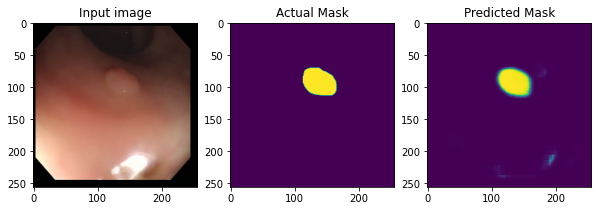

In [36]:
# print sample image after training
print_images()

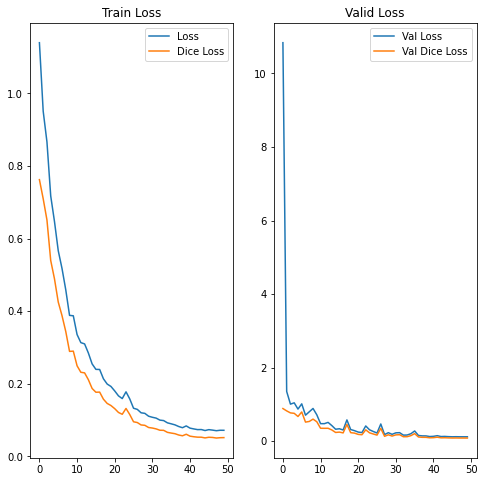

In [37]:
dice_loss = history.history['dice_loss']
loss = history.history['loss']
val_dice_loss = history.history['val_dice_loss']
val_loss = history.history['val_loss']

epochs_range = range(max_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Loss')
plt.plot(epochs_range, dice_loss, label='Dice Loss')
plt.legend(loc='upper right')
plt.title('Train Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.plot(epochs_range, val_dice_loss, label='Val Dice Loss')
plt.legend(loc='upper right')
plt.title('Valid Loss')
plt.show()

In [38]:
# restoring the latest checkpoint in checkpoint_dir
model.load_weights(checkpoint_dir)

In [39]:
def mean_iou(y_true, y_pred, num_classes=2):
    # Flatten  
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    y_true_f = tf.cast(tf.round(y_true_f), dtype=tf.int32).numpy()
    y_pred_f = tf.cast(tf.round(y_pred_f), dtype=tf.int32).numpy()

    # calculate confusion matrix
    labels = list(range(num_classes))
    current = confusion_matrix(y_true_f, y_pred_f, labels=labels)

    # compute mean iou
    intersection = np.diag(current)
    ground_truth_set = current.sum(axis=1)
    predicted_set = current.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection

    IoU = intersection / union.astype(np.float32)
    return np.mean(IoU)

In [40]:
mean = []

for images, labels in test_dataset:
    predictions = model(images, training=False)
    m = mean_iou(labels, predictions)
    mean.append(m)

mean = np.array(mean)
mean = np.mean(mean)
print("mean_iou: {}".format(mean))

mean_iou: 0.9003091166515621


In [55]:
## Define print function
def print_images():
    for test_images, test_labels in test_dataset.take(1):
        predictions = model(test_images, training=False)

        for i in range(batch_size):
            plt.figure(figsize=(10, 20))
            plt.subplot(1, 3, 1)
            plt.imshow(test_images[i,: , :, :])
            plt.title("Input image")

            plt.subplot(1, 3, 2)
            plt.imshow(test_labels[i, :, :, 0])
            plt.title("Actual Mask")

            plt.subplot(1, 3, 3)
            plt.imshow(predictions[i, :, :, 0])
            plt.title("Predicted Mask")
            plt.show()

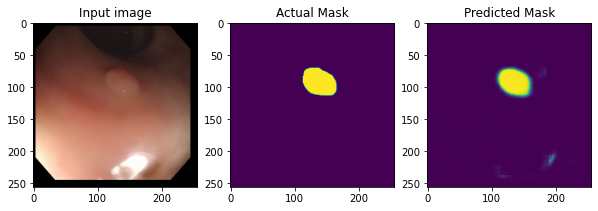

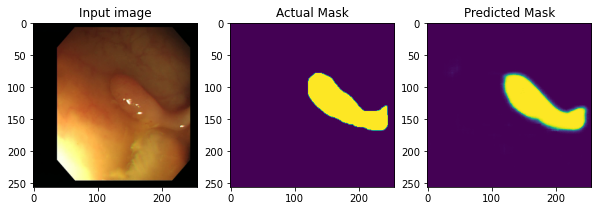

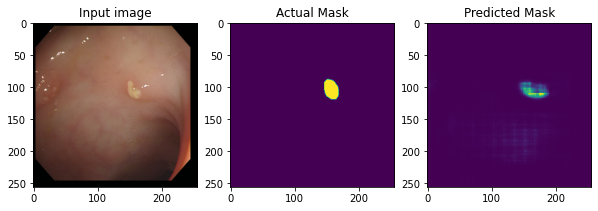

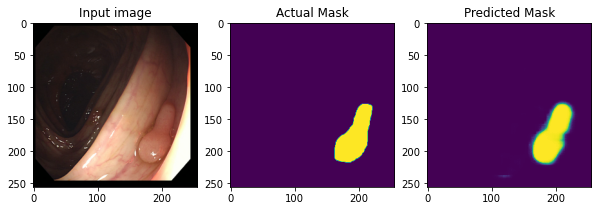

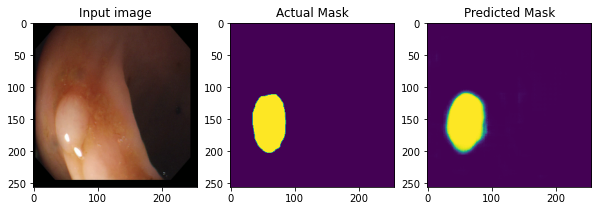

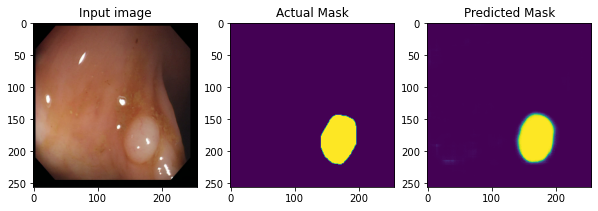

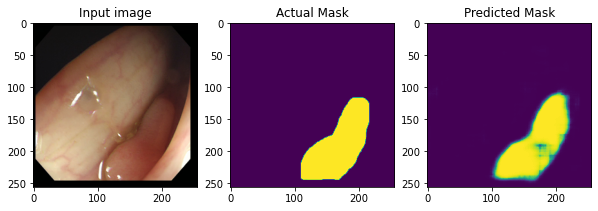

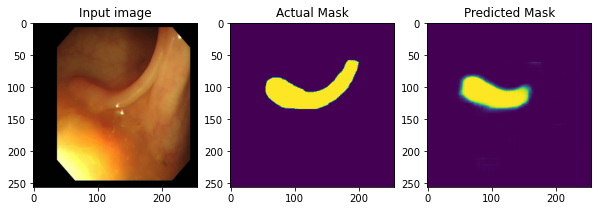

In [56]:
print_images()

###  unet 모델은  https://github.com/comcomet/first-repository/blob/master/E27/E27.ipynb

### pretrained 는 진행하지 못했습니다.

In [46]:
vgg16 = tf.keras.applications.VGG16(input_shape=img_shape,
                                         include_top=False,
                                         weights='imagenet')
layer_outputs = [layer.output for layer in vgg16.layers]
layer_outputs

[<tf.Tensor 'input_2:0' shape=(None, 256, 256, 3) dtype=float32>,
 <tf.Tensor 'block1_conv1/Relu_1:0' shape=(None, 256, 256, 64) dtype=float32>,
 <tf.Tensor 'block1_conv2/Relu_1:0' shape=(None, 256, 256, 64) dtype=float32>,
 <tf.Tensor 'block1_pool/MaxPool_1:0' shape=(None, 128, 128, 64) dtype=float32>,
 <tf.Tensor 'block2_conv1/Relu_1:0' shape=(None, 128, 128, 128) dtype=float32>,
 <tf.Tensor 'block2_conv2/Relu_1:0' shape=(None, 128, 128, 128) dtype=float32>,
 <tf.Tensor 'block2_pool/MaxPool_1:0' shape=(None, 64, 64, 128) dtype=float32>,
 <tf.Tensor 'block3_conv1/Relu_1:0' shape=(None, 64, 64, 256) dtype=float32>,
 <tf.Tensor 'block3_conv2/Relu_1:0' shape=(None, 64, 64, 256) dtype=float32>,
 <tf.Tensor 'block3_conv3/Relu_1:0' shape=(None, 64, 64, 256) dtype=float32>,
 <tf.Tensor 'block3_pool/MaxPool_1:0' shape=(None, 32, 32, 256) dtype=float32>,
 <tf.Tensor 'block4_conv1/Relu_1:0' shape=(None, 32, 32, 512) dtype=float32>,
 <tf.Tensor 'block4_conv2/Relu_1:0' shape=(None, 32, 32, 512) d

In [44]:
class Vgg16UNet(tf.keras.Model):
    def __init__(self):
        super(Vgg16UNet, self).__init__()
        self.vgg16 = tf.keras.applications.VGG16(input_shape=img_shape,
                                         include_top=False,
                                         weights='imagenet')
        layer_outputs = [layer.output for layer in self.vgg16.layers]
        self.vgg16_act = models.Model(inputs=self.vgg16.input, 
                                      outputs=[layer_outputs[2], 
                                               layer_outputs[5], 
                                               layer_outputs[9], 
                                               layer_outputs[13], 
                                               layer_outputs[17]])


        self.center = ConvBlock(1024)

        self.decoder_block4 = DecoderBlock(512)
        self.decoder_block3 = DecoderBlock(256)
        self.decoder_block2 = DecoderBlock(128)
        self.decoder_block1 = DecoderBlock(64)

        self.output_conv = layers.Conv2D(1, 1, activation='sigmoid')

    def call(self, inputs, training=True):

        encoder1, encoder2, encoder3, encoder4, center = self.vgg16_act(inputs) 

        decoder4 = self.decoder_block4(center, encoder4)
        decoder3 = self.decoder_block3(decoder4, encoder3)
        decoder2 = self.decoder_block2(decoder3, encoder2)
        decoder1 = self.decoder_block1(decoder2, encoder1)
        
        outputs = self.output_conv(decoder1)

        return outputs